In [5]:
from tcn import TCN
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

In [6]:
X_train = pd.read_csv("../../../Split Data/Training Dataset/X_train #1.csv").drop(columns=["Unnamed: 0"])
y_train = pd.read_csv("../../../Split Data/Training Dataset/y_train #1.csv", index_col=0)
X_val = pd.read_csv("../../../Split Data/Validation Dataset/X_val #1.csv").drop(columns=["Unnamed: 0"])
y_val = pd.read_csv("../../../Split Data/Validation Dataset/y_val #1.csv", index_col=0)
X_test = pd.read_csv("../../../Split Data/Testing Dataset/X_test #1.csv").drop(columns=["Unnamed: 0"])
y_test = pd.read_csv("../../../Split Data/Testing Dataset/y_test #1.csv", index_col=0)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)   
X_test_scaled = scaler.transform(X_test) 

In [8]:
X_train = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  
X_val = np.array(X_val_scaled).reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)  
X_test = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)  

In [9]:
num_classes = 2   
kernel_size = 5
dilations = [4, 8, 16, 32, 64] 
max_len = X_train.shape[1] 
dropout_rate = 0.05

In [10]:
inputs = Input(shape=(max_len, 1))

In [23]:
tcn = TCN(
    nb_filters= 128,
    nb_stacks = 2,
    kernel_size=kernel_size,
    dilations=dilations,
    dropout_rate=dropout_rate,
    use_layer_norm=True,
    return_sequences = True
)(inputs)

In [12]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [13]:
max_pooling = GlobalMaxPooling1D()(tcn)

In [14]:
avg_pooling = GlobalAveragePooling1D()(tcn)

In [15]:
pooling = Concatenate()([max_pooling, avg_pooling])

In [16]:
dense1 = Dense(64, activation= 'relu')(pooling)

In [17]:
dropout1 = Dropout(0.2)(dense1)

In [18]:
outputs = Dense(2, activation='softmax')(dropout1)

In [19]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [20]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11, 1)]              0         []                            
                                                                                                  
 tcn (TCN)                   (None, 11, 128)              1565056   ['input_1[0][0]']             
                                                                                                  
 global_max_pooling1d (Glob  (None, 128)                  0         ['tcn[0][0]']                 
 alMaxPooling1D)                                                                                  
                                                                                                  
 global_average_pooling1d (  (None, 128)                  0         ['tcn[0][0]']             

In [21]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (484032, 2)
y_val shape: (67526, 2)


In [24]:
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val), verbose = 1, 
          callbacks = 
          [ModelCheckpoint(filepath="TCN #1.h5", 
          monitor='val_f1', mode='max',save_best_only=True), 
          EarlyStopping(monitor='val_f1', patience =5, 
          restore_best_weights= True, mode ="max")], 
          batch_size = 128)

Epoch 1/100


3782/3782 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.7721 - f1: 0.7721

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3782/3782 [==============================] - 199s 53ms/step - loss: 0.4439 - accuracy: 0.7721 - f1: 0.7721 - val_loss: 0.4186 - val_accuracy: 0.8167 - val_f1: 0.8168
Epoch 2/100
3782/3782 [==============================] - 197s 52ms/step - loss: 0.4397 - accuracy: 0.7744 - f1: 0.7744 - val_loss: 0.4087 - val_accuracy: 0.8140 - val_f1: 0.8140
Epoch 3/100
3782/3782 [==============================] - 196s 52ms/step - loss: 0.4371 - accuracy: 0.7760 - f1: 0.7760 - val_loss: 0.4006 - val_accuracy: 0.8290 - val_f1: 0.8290
Epoch 4/100
3782/3782 [==============================] - 196s 52ms/step - loss: 0.4353 - accuracy: 0.7773 - f1: 0.7773 - val_loss: 0.4436 - val_accuracy: 0.7628 - val_f1: 0.7628
Epoch 5/100
3782/3782 [==============================] - 194s 51ms/step - loss: 0.4335 - accuracy: 0.7787 - f1: 0.7787 - val_loss: 0.4105 - val_accuracy: 0.7977 - val_f1: 0.7977
Epoch 6/100
3782/3782 [==============================] - 194s 51ms/step - loss: 0.4324 - accuracy: 0.7797 - f1: 0.7797 - v

In [25]:
TCN_model = load_model('TCN #1.h5', custom_objects={'f1': f1})

In [26]:
y_test = to_categorical(y_test, 2)

In [27]:
results = TCN_model.evaluate(X_test, y_test, verbose = 1)

2111/2111 [==============================] - 34s 16ms/step - loss: 0.3987 - accuracy: 0.8302 - f1: 0.8302


In [28]:
y_pred = TCN_model.predict(X_test)

2111/2111 [==============================] - 33s 15ms/step


In [29]:
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

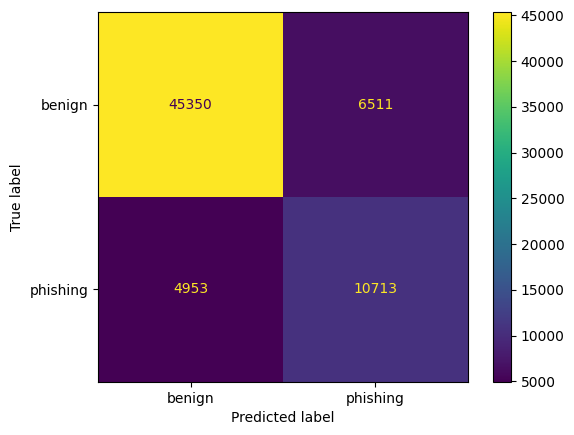

In [30]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["benign", "phishing"])                            
matrix.plot()

In [31]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1_score = metrics.f1_score(y_test, y_pred)

In [32]:
print({"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"F1_score":F1_score})

{'Accuracy': 0.8302308706147171, 'Precision': 0.6219809568044589, 'Recall': 0.6838376101110686, 'F1_score': 0.6514442079659472}


In [36]:
df = pd.read_csv("../Metrics of Dataset #1.csv")

In [37]:
metrics = pd.DataFrame({"Model": "TCN", "Accuracy": [Accuracy], "Precision":[Precision], "Recall": [Recall], "F1_score": [F1_score]})

In [38]:
df = pd.concat([df, metrics], ignore_index=True)

In [39]:
df.head()

,Model,Accuracy,Precision,Recall,F1_score
0,LinearSVC,0.718824,0.433593,0.692072,0.533156
1,Random Forest,0.824603,0.604040,0.708222,0.651995
2,XGBoost,0.811364,0.574300,0.722329,0.639864
3,MLP,0.818547,0.589332,0.718626,0.647588
4,TCN,0.830231,0.621981,0.683838,0.651444


In [40]:
df.to_csv("../Metrics of Dataset #1.csv", index=False)